#Rainfall Prediction Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_auc_score,
                             roc_curve, classification_report)
from sklearn.pipeline import Pipeline

In [ ]:
df = pd.read_csv('Temp_and_rain.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Task 1:EDA

In [ ]:
print("\n=== Enhanced Data Exploration ===")
print("Data Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nDescriptive Statistics:\n", df.describe(include='all'))


=== Enhanced Data Exploration ===
Data Shape: (1380, 4)

Data Types:
 tem      float64
Month      int64
Year       int64
rain     float64
dtype: object

Descriptive Statistics:
                tem        Month        Year         rain
count  1380.000000  1380.000000  1380.00000  1380.000000
mean     25.066213     6.500000  1958.00000   203.275431
std       3.682411     3.453304    33.20842   202.730898
min      16.800600     1.000000  1901.00000     0.000000
25%      22.114125     3.750000  1929.00000    18.498850
50%      27.012950     6.500000  1958.00000   145.086000
75%      28.007850     9.250000  1987.00000   347.639500
max      29.526000    12.000000  2015.00000  1012.020000


In [ ]:
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

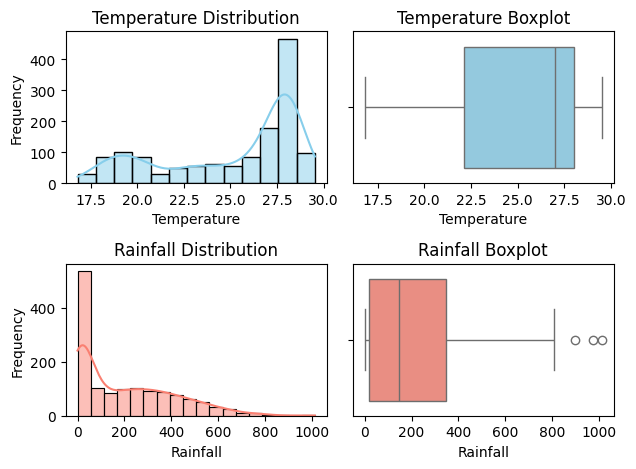

In [ ]:
plt.subplot(2, 2, 1)
sns.histplot(df['tem'], kde=True, color='skyblue')
plt.title('Temperature Distribution', fontsize=12)
plt.xlabel('Temperature', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

plt.subplot(2, 2, 2)
sns.boxplot(x=df['tem'], color='skyblue')
plt.title('Temperature Boxplot', fontsize=12)
plt.xlabel('Temperature', fontsize=10)

plt.subplot(2, 2, 3)
sns.histplot(df['rain'], kde=True, color='salmon')
plt.title('Rainfall Distribution', fontsize=12)
plt.xlabel('Rainfall', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

plt.subplot(2, 2, 4)
sns.boxplot(x=df['rain'], color='salmon')
plt.title('Rainfall Boxplot', fontsize=12)
plt.xlabel('Rainfall', fontsize=10)

plt.tight_layout()
plt.show()

# Bivariate Analysis

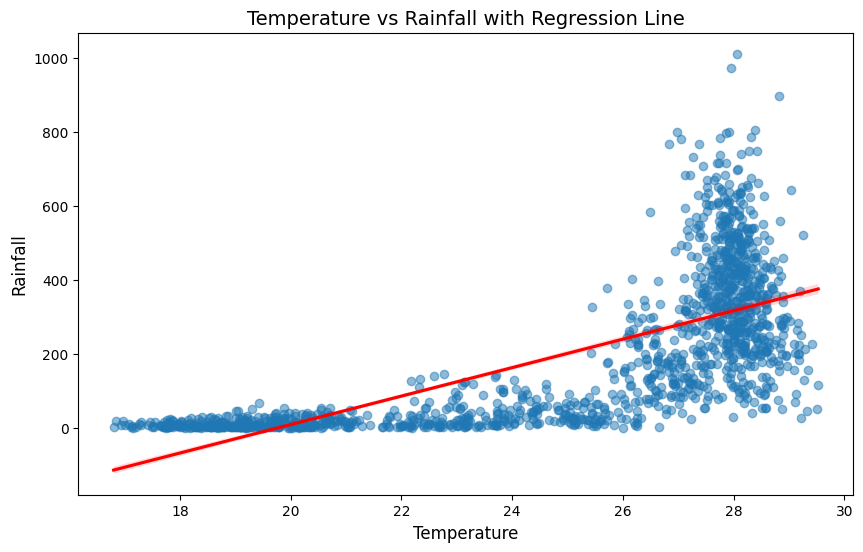

In [ ]:
plt.figure(figsize=(10, 6))
sns.regplot(x='tem', y='rain', data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Temperature vs Rainfall with Regression Line', fontsize=14)
plt.xlabel('Temperature', fontsize=12)
plt.ylabel('Rainfall', fontsize=12)
plt.show()

#Multivariate Analysis

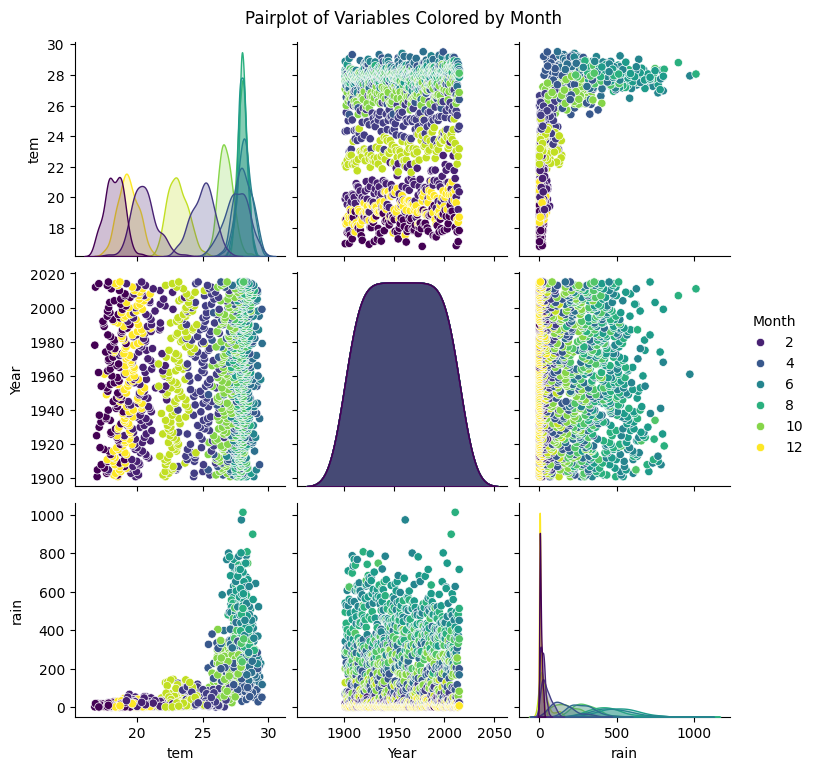

In [ ]:
sns.pairplot(df, hue='Month', palette='viridis')
plt.suptitle('Pairplot of Variables Colored by Month', y=1.02)
plt.show()

#Time series analysis

<Figure size 1200x600 with 0 Axes>

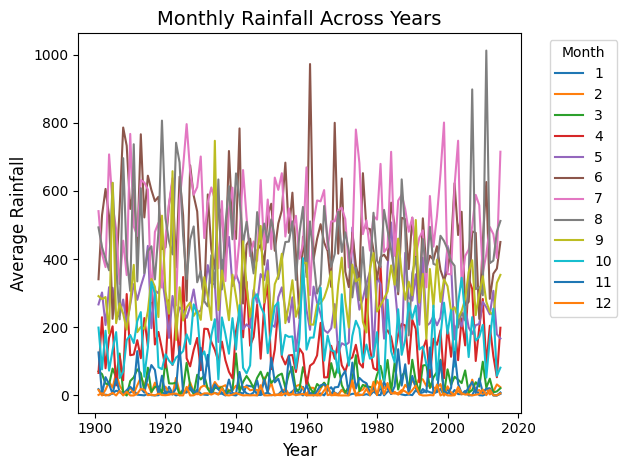

In [ ]:
plt.figure(figsize=(12, 6))
df.groupby(['Year', 'Month'])['rain'].mean().unstack().plot()
plt.title('Monthly Rainfall Across Years', fontsize=14)
plt.ylabel('Average Rainfall', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Correlation heatmap

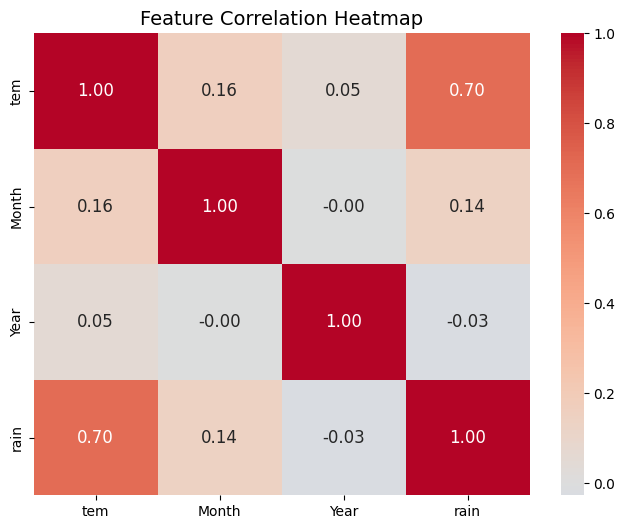

In [ ]:
plt.figure(figsize=(8, 6))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0,
            annot_kws={"size": 12}, fmt='.2f')
plt.title('Feature Correlation Heatmap', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

#Task 2: Data Preprocessing

In [ ]:
print("\n=== Data Preprocessing ===")


=== Data Preprocessing ===


In [ ]:
missing_values = df.isnull().sum()
print("Missing values before treatment:\n", missing_values)
print("\nTotal Missing Values:", missing_values.sum())

Missing values before treatment:
 tem      0
Month    0
Year     0
rain     0
dtype: int64

Total Missing Values: 0


# Calculate IQR for rainfall

In [ ]:
Q1 = df['rain'].quantile(0.25)
Q3 = df['rain'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"\nRainfall Outlier Bounds: Lower={lower_bound:.2f}, Upper={upper_bound:.2f}")

# Cap outliers
df['rain'] = np.where(df['rain'] > upper_bound, upper_bound,
                     np.where(df['rain'] < lower_bound, lower_bound, df['rain']))


Rainfall Outlier Bounds: Lower=-475.21, Upper=841.35


#Skewness

In [ ]:
print(f"\nSkewness before transformation: {df['rain'].skew():.2f}")

df['rain_log'] = np.log1p(df['rain'])
print(f"Skewness after log transformation: {df['rain_log'].skew():.2f}")


Skewness before transformation: 0.81
Skewness after log transformation: -0.74


#Feature Engineering

In [ ]:
rain_median = df['rain'].median()
df['rain_class'] = (df['rain'] > rain_median).astype(int)

#Scaling

In [ ]:

X = df[['tem', 'Month', 'Year']]
y = df['rain_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Class Imbalance Handling

In [ ]:
print("\nClass Distribution Before SMOTE:")
print(y_train.value_counts())
print(y_train.value_counts(normalize=True) * 100)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print("\nClass Distribution After SMOTE:")
print(pd.Series(y_train_res).value_counts())
print(pd.Series(y_train_res).value_counts(normalize=True) * 100)


Class Distribution Before SMOTE:
rain_class
1    562
0    542
Name: count, dtype: int64
rain_class
1    50.905797
0    49.094203
Name: proportion, dtype: float64

Class Distribution After SMOTE:
rain_class
0    562
1    562
Name: count, dtype: int64
rain_class
0    50.0
1    50.0
Name: proportion, dtype: float64


# Task 3: Model Training

In [ ]:
print("\n=== Model Training ===")


=== Model Training ===


In [ ]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
}

#Hyperparameter Tuning

In [ ]:
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l2']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }
}

# Train and tune models

In [ ]:
trained_models = {}
for name, model in models.items():
    print(f"\nTraining {name}...")

    if name in param_grids:
        # Perform grid search for models with parameter grids
        grid_search = GridSearchCV(model, param_grids[name],
                                 cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_res, y_train_res)
        trained_models[name] = grid_search.best_estimator_
        print(f"Best parameters for {name}: {grid_search.best_params_}")
        print(f"Best CV accuracy: {grid_search.best_score_:.4f}")
    else:
        # Fit models without parameter grids
        model.fit(X_train_res, y_train_res)
        trained_models[name] = model


Training Random Forest...
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Best CV accuracy: 0.9289

Training SVM...
Best parameters for SVM: {'C': 10, 'kernel': 'rbf'}
Best CV accuracy: 0.9297

Training Logistic Regression...
Best parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l2'}
Best CV accuracy: 0.9155

Training KNN...
Best parameters for KNN: {'n_neighbors': 5, 'weights': 'distance'}
Best CV accuracy: 0.9351

Training Gradient Boosting...

Training Neural Network...


#Ensemble Model

In [ ]:
print("\nCreating Ensemble Model...")
ensemble = VotingClassifier(
    estimators=[
        ('rf', trained_models['Random Forest']),
        ('gb', trained_models['Gradient Boosting']),
        ('lr', trained_models['Logistic Regression'])
    ],
    voting='soft'
)
ensemble.fit(X_train_res, y_train_res)
trained_models['Ensemble'] = ensemble


Creating Ensemble Model...


# Task 4:Model Evaluation

In [ ]:
print("\n=== Model Evaluation ===")


=== Model Evaluation ===


In [ ]:
# 1. Performance Metrics Table
results = []
for name, model in trained_models.items():
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob) if y_prob is not None else None
    })

In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\nPerformance Comparison:")
print(results_df.to_string(index=False))


Performance Comparison:
              Model  Accuracy  Precision   Recall       F1  ROC AUC
      Random Forest  0.905797   0.880597 0.921875 0.900763 0.984058
                SVM  0.923913   0.868966 0.984375 0.923077 0.989337
Logistic Regression  0.887681   0.821192 0.968750 0.888889 0.953125
                KNN  0.916667   0.900763 0.921875 0.911197 0.986486
  Gradient Boosting  0.905797   0.875000 0.929688 0.901515 0.976774
     Neural Network  0.913043   0.876812 0.945312 0.909774 0.986064
           Ensemble  0.898551   0.852113 0.945312 0.896296 0.981261


#ROC Curves

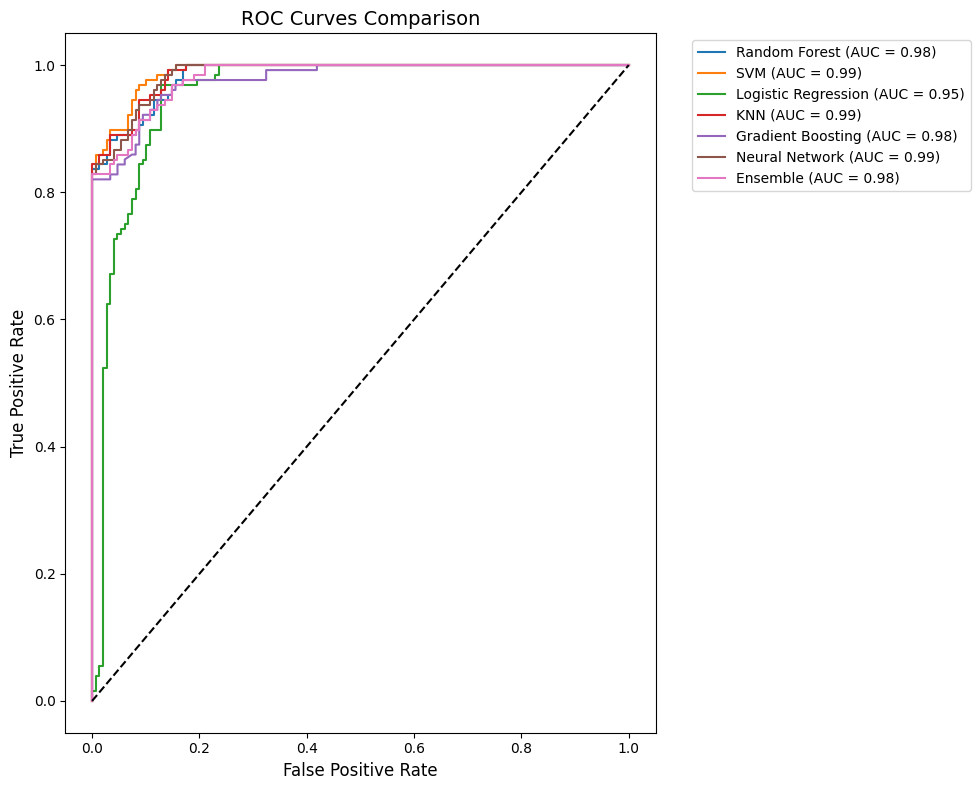

In [ ]:
plt.figure(figsize=(10, 8))
for name, model in trained_models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#Confusion Matrix

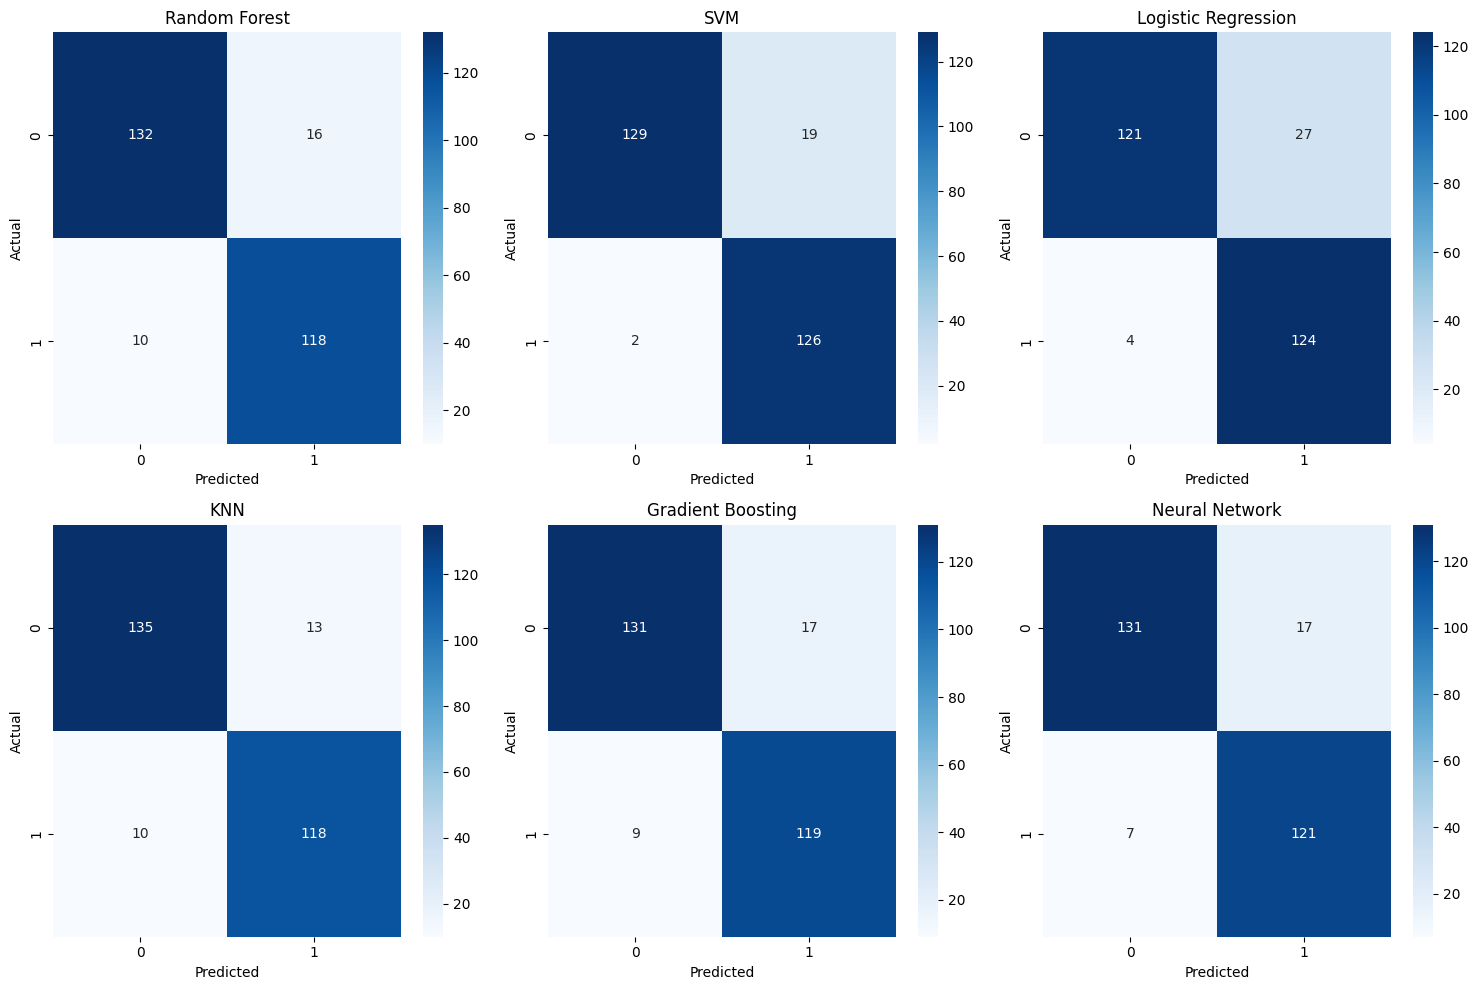

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for (name, model), ax in zip(trained_models.items(), axes):
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(name, fontsize=12)
    ax.set_xlabel('Predicted', fontsize=10)
    ax.set_ylabel('Actual', fontsize=10)

plt.tight_layout()
plt.show()

#Classification Report

In [ ]:
print("\nDetailed Classification Reports:")
for name, model in trained_models.items():
    y_pred = model.predict(X_test_scaled)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))


Detailed Classification Reports:

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       148
           1       0.88      0.92      0.90       128

    accuracy                           0.91       276
   macro avg       0.91      0.91      0.91       276
weighted avg       0.91      0.91      0.91       276


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       148
           1       0.87      0.98      0.92       128

    accuracy                           0.92       276
   macro avg       0.93      0.93      0.92       276
weighted avg       0.93      0.92      0.92       276


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       148
           1       0.82      0.97      0.89       128

    accuracy                          

#Model Comparison

In [ ]:
print("\n=== Final Model Comparison ===")
print("Based on the evaluation metrics, the best performing models are:")
print(results_df.sort_values('F1', ascending=False).head(3).to_string(index=False))


=== Final Model Comparison ===
Based on the evaluation metrics, the best performing models are:
         Model  Accuracy  Precision   Recall       F1  ROC AUC
           SVM  0.923913   0.868966 0.984375 0.923077 0.989337
           KNN  0.916667   0.900763 0.921875 0.911197 0.986486
Neural Network  0.913043   0.876812 0.945312 0.909774 0.986064
